In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import  imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.3)
train_dataset=train_datagen.flow_from_directory(directory='/content/drive/MyDrive/data/train/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True,
                                                batch_size=64)
validation_dataset=train_datagen.flow_from_directory(directory='/content/drive/MyDrive/data/train/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=True,
                                                batch_size=64)

test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_dataset=test_datagen.flow_from_directory(directory='/content/drive/MyDrive/data/test/',
                                                target_size=(160,160),
                                                class_mode='categorical',
                                                subset='training',
                                                shuffle=True,
                                                batch_size=64)

Found 4200 images belonging to 20 classes.
Found 1800 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


In [4]:
IMG_SHAPE = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [5]:
for layer in base_model.layers[:140]:
  layer.trainable=False

for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 Conv1 - False
2 bn_Conv1 - False
3 Conv1_relu - False
4 expanded_conv_depthwise - False
5 expanded_conv_depthwise_BN - False
6 expanded_conv_depthwise_relu - False
7 expanded_conv_project - False
8 expanded_conv_project_BN - False
9 block_1_expand - False
10 block_1_expand_BN - False
11 block_1_expand_relu - False
12 block_1_pad - False
13 block_1_depthwise - False
14 block_1_depthwise_BN - False
15 block_1_depthwise_relu - False
16 block_1_project - False
17 block_1_project_BN - False
18 block_2_expand - False
19 block_2_expand_BN - False
20 block_2_expand_relu - False
21 block_2_depthwise - False
22 block_2_depthwise_BN - False
23 block_2_depthwise_relu - False
24 block_2_project - False
25 block_2_project_BN - False
26 block_2_add - False
27 block_3_expand - False
28 block_3_expand_BN - False
29 block_3_expand_relu - False
30 block_3_pad - False
31 block_3_depthwise - False
32 block_3_depthwise_BN - False
33 block_3_depthwise_relu - False
34 block_3_project - Fal

In [6]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(20, activation='softmax')

In [7]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy',keras.metrics.Recall(name='recall'),keras.metrics.Precision(name='precision'),keras.metrics.AUC(name='auc')])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 2,283,604
Trainable params: 1,065,620
Non-trainable params: 1,217,984
_________________________________________________________________


In [9]:
validation_steps=20
initial_epochs = 25

In [10]:
checkpoint_filepath = '/content/drive/MyDrive/data/'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,verbose=1,shuffle=True)

Epoch 1/25


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


66/66 [==============================] - 1457s 22s/step - loss: 1.0974 - accuracy: 0.6888 - recall: 0.4595 - precision: 0.9182 - auc: 0.9684 - val_loss: 1.5540 - val_accuracy: 0.4611 - val_recall: 0.2717 - val_precision: 0.6000 - val_auc: 0.9317
Epoch 2/25
66/66 [==============================] - 111s 2s/step - loss: 0.2712 - accuracy: 0.9381 - recall: 0.8929 - precision: 0.9610 - auc: 0.9990 - val_loss: 1.1449 - val_accuracy: 0.6078 - val_recall: 0.4367 - val_precision: 0.7285 - val_auc: 0.9632
Epoch 3/25
66/66 [==============================] - 111s 2s/step - loss: 0.1410 - accuracy: 0.9795 - recall: 0.9645 - precision: 0.9854 - auc: 0.9998 - val_loss: 0.8962 - val_accuracy: 0.7039 - val_recall: 0.5761 - val_precision: 0.8020 - val_auc: 0.9765
Epoch 4/25
66/66 [==============================] - 113s 2s/step - loss: 0.0861 - accuracy: 0.9907 - recall: 0.9848 - precision: 0.9942 - auc: 1.0000 - val_loss: 0.7797 - val_accuracy: 0.7389 - val_recall: 0.6489 - val_precision: 0.8168 - val_a

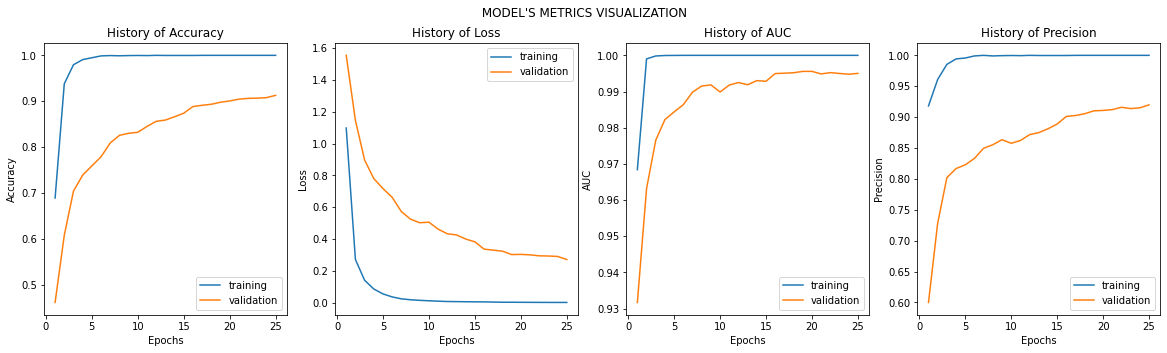

In [12]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
              )

In [13]:
model.save("mobilenetv2.hdf5")

In [14]:
model = keras.models.load_model("mobilenetv2.hdf5")
model.evaluate(test_dataset)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 [==============================] - 478s 15s/step - loss: 0.2983 - accuracy: 0.9030 - recall: 0.8885 - precision: 0.9165 - auc: 0.9946


[0.29833799600601196,
 0.902999997138977,
 0.8884999752044678,
 0.9164517521858215,
 0.994634211063385]

<ipython-input-16-76787b75b307>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


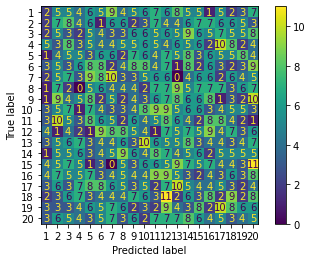

Classification Report
              precision    recall  f1-score   support

           1       0.04      0.02      0.03       100
           2       0.07      0.07      0.07       100
           3       0.03      0.03      0.03       100
           4       0.04      0.03      0.03       100
           5       0.03      0.03      0.03       100
           6       0.08      0.08      0.08       100
           7       0.10      0.10      0.10       100
           8       0.04      0.04      0.04       100
           9       0.04      0.04      0.04       100
          10       0.08      0.08      0.08       100
          11       0.05      0.05      0.05       100
          12       0.05      0.07      0.06       100
          13       0.05      0.05      0.05       100
          14       0.04      0.05      0.05       100
          15       0.05      0.05      0.05       100
          16       0.04      0.04      0.04       100
          17       0.05      0.05      0.05       100
     

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))